In [25]:
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import *
sc.stop()
from pyspark.sql import SQLContext
conf = SparkConf().setAppName("App")
conf = (conf.set('spark.driver.memory', '60G').set("spark.yarn.executor.memoryOverhead", '4096'))
sc =SparkContext(conf=conf)
sqlContext = SQLContext(sc)
import pyspark.sql.functions as func
import sys
from pyspark.sql.functions import countDistinct

In [26]:
#reading in sticker type data
feature_data = sqlContext.read.parquet("gs://ds-url-catag/stick_statistics/derived_features/")


In [27]:
#sampling of the data 
from pyspark.sql import functions as F
from pyspark.sql.window import Window

feature_data = feature_data.withColumn("row_number", F.row_number().over(Window.orderBy('user_id_n')))
feature_data = feature_data.withColumn("by_20k",lit(200))
feature_data = feature_data.withColumn("modulo",feature_data.row_number%feature_data.by_20k)
test_data = feature_data.where(col('modulo') == 0)

In [28]:
#write the sample data to a file 
test_data.limit(20000).write.mode('overwrite').parquet("gs://ds-url-catag/clustering/clust_test_data")

In [29]:
#reading in the sample data 
feature_test = sqlContext.read.parquet("gs://ds-url-catag/clustering/clust_test_data/")

In [30]:
feature_test.count()

20000

In [31]:
#convert pyspark to pandas dataframe
import pandas as pd
import pyarrow.parquet as pq
feature_data_df  = feature_test.toPandas()

In [32]:
#checking size of dataframe
print 'Size of the dataframe: {}'.format(feature_data_df.shape)

Size of the dataframe: (20000, 12)


In [33]:
#logarithmic transformation of two different variables
import numpy as np
feature_data_df['log_noofdays']=np.log10(1+feature_data_df.numofdays)
feature_data_df['log_avg_con_days']=np.log10(1+feature_data_df.avg_con_days)
feature_data_df['log_sticker_packs_sent']=np.log10(1+feature_data_df.sticker_packs_sent)
feature_data_df['log_distinct_sticker_packs_sent']=np.log10(1+feature_data_df.distinct_sticker_packs_sent)
feature_data_df['log_sum_paid']=np.log10(1+feature_data_df.sum_paid)
feature_data_df['log_sum_free']=np.log10(1+feature_data_df.sum_free)
feature_data_df['log_sum_subs']=np.log10(1+feature_data_df.sum_subs)
feature_data_df['log_sum_discont']=np.log10(1+feature_data_df.sum_discont)


In [79]:
import time

from sklearn.manifold import TSNE

n_sne = 20000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature_data_df[['log_noofdays','log_avg_con_days','log_sticker_packs_sent','log_distinct_sticker_packs_sent','log_sum_paid','log_sum_free','log_sum_subs','log_sum_discont']].values)

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.089s...
[t-SNE] Computed neighbors for 20000 samples in 3.382s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

In [80]:
#assigning tsne data to the feature dataset 
feature_data_df['tsne_one'] = tsne_results[:,0]
feature_data_df['tsne_two'] = tsne_results[:,1]


In [81]:
intermediate_data = feature_data_df[['tsne_one','tsne_two']]

In [82]:
X = intermediate_data.as_matrix(columns=intermediate_data.columns)

In [83]:
#Kmeans cluster 
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=9, random_state=10)
cluster_labels = clusterer.fit_predict(intermediate_data)

print 

In [88]:
# clusterer.labels_
feature_data_df['clusters'] = clusterer.labels_

In [84]:
import matplotlib.cm as cm
colors = cm.spectral(cluster_labels.astype(float) / 9)

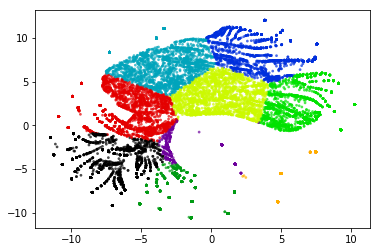

In [85]:
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1)

ax1.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

plt.show()


In [73]:
# from ggplot import *

# feature_data_df['tsne_one'] = tsne_results[:,0]
# feature_data_df['tsne_two'] = tsne_results[:,1]

# chart = ggplot(intermediate_data, aes(x='tsne_one', y='tsne_two',color = colors) ) \
#         + geom_point(size=70,alpha=0.1) \
#         + ggtitle("tSNE dimensions colored by clusters")
# chart

